# Projets: Suggestions de Tags 


Après avoir procéder à la préparation du jeu de données dans le notebook précédent, nous allons maintenant modéliser le système de suggestion des tags. Quatre approches de classifications seront présentées ici:
  1. Bag-of-Words : Suggestion à partir d'un modèle LDA (*Topic Modelling*) 
  2. Embedding : 
      2.1 Word2Vec
      2.2 BERT
      2.3 Universal Sentence Encoder (USE)
      
  
# <font color="#00afe6">Sommaire</font>
1. [Préparation du jeu de données.](#section_1)                       
2. [Train / val / test split.](#section_2)     
3. [Suggestion non-supervisée avec LDA.](#section_3)     
    3.1 [Recherche du nombre de topics optimal.](#section_3_1)            
    3.2 [Fonction "score" pour le système de suggestion.](#section_3_2)            
    3.3 [Inférence sur le test set.](#section_3_3)            
4. [Suggestion avec modèle Word2Vec.](#section_4) 
5. [Modélisation via Transfer Learning.](#section_5)               
    5.1 [Suggestion avec le modèle BERT.](#section_5_1)            
    5.2 [Suggestion avec le modèle USE.](#section_5_2)            

In [1]:
# Importation des librairies python

import sys, time
from random import randint

import re, numpy as np, pandas as pd, seaborn as sns
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
%matplotlib inline


from random import randint
from tqdm import tqdm
tqdm.pandas()

import logging, warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import gensim 

import tensorflow as tf
import tensorflow.keras as keras 

In [2]:
df = pd.read_csv('df_cleaned.csv', index_col=0)

print("Le dataframe contient {} colonnes et {} lignes."\
      .format(df.shape[1],df.shape[0]))

Le dataframe contient 3 colonnes et 37960 lignes.


# <font color="blue" id=section_1> 1. Préparation du jeu de données. </font>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37960 entries, 689677 to 665299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Best_Tags  37960 non-null  object
 1   Body_pc    37960 non-null  object
 2   Body_lm    37960 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Le dataframe contient deux colonnes de textes ( et ) qui seront utilisées selon le modèle. La colonne `Body_lm` contient du texte qui a été *tokenized* et *lemmatized* sera utilisée pour les modèles LDA et Word2Vec. La colonne
`Body_pc` qui contient les textes pré-nettoyés sera utilisée pour le transfert learning.

La colonne `Best_Tags` est la colonne cible.

In [4]:
from ast import literal_eval

df["Best_Tags"] = df["Best_Tags"].progress_apply(lambda x: literal_eval(x))

100%|██████████| 37960/37960 [00:00<00:00, 124273.35it/s]


In [5]:
def split_and_count_tags(df, column, separator):
    list_words = []
    for word in df[column]: #.str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

tags_list_df = split_and_count_tags(df=df, column='Best_Tags', separator=',')
tags_list_df.head()

,tag_count
Tag,
python,4528
java,4293
c#,4088
javascript,4070
android,2776


In [6]:
nbr_tags = tags_list_df.shape[0]

print("Le jeu de données compte {} tags.".format(nbr_tags))
tags_list = tags_list_df.reset_index()['Tag'].values.tolist()

Le jeu de données compte 35 tags.


Dans le but d'avoir une modélisation rapide et légère, la taille maximale du corps du texte sera encore réduite. Nous appliquerons cette fois-ci le filtre sur la colonne `Body_lm`.

In [7]:
maxSeq_len = 64

data_long=[]
data_idx=[]

for i,data in df['Body_lm'].apply(lambda x: x.split(" ")).items():
    if (len(data) < maxSeq_len):
        data_idx.append(i)
    else:
        data_long.append(i)

df = df.loc[data_idx]

print("Le dataframe compte à présent {} lignes.".format(df.shape[0]))

Le dataframe compte à présent 32644 lignes.


In [8]:
def token_distribution(df,col):
    tk = [len(body) for body in df[col].apply(lambda x: x.split(" "))]
    print(f"\n Le corps de texte le plus long contient {max(tk)} tokens. \n")

    plt.figure(figsize=(15,6))
    plt.hist(tk, bins=100)
    plt.title(f"Distribution du nombre de token dans la colonne {col}", fontsize=18)
    plt.xlabel('Nombre de tokens', fontsize=18)
    plt.xticks(fontsize=15)
    plt.ylabel('Nombre de lignes', fontsize=18 )
    plt.yticks(fontsize=15)
    plt.show()


 Le corps de texte le plus long contient 63 tokens. 



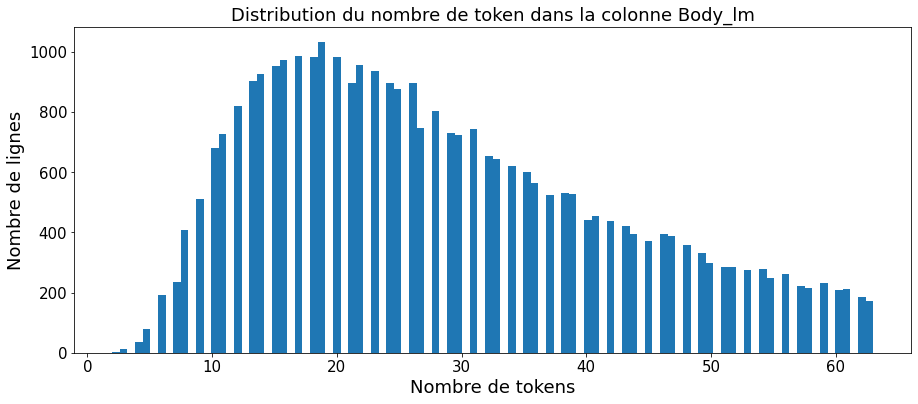

In [9]:
token_distribution(df, 'Body_lm')

# <font color="blue" id=section_2> 2. Train / val / test split. </font>

In [10]:
def split_train_test_val(dataset, train_ratio = 0.9):
      
    # shuffle dataset
    dataset = dataset.sample(frac=1)

    # train set
    np.random.seed(seed=0)
    train_msk = np.random.rand(len(df)) < train_ratio
    train_df = dataset[train_msk]
    print('train_df shape = ', train_df.shape)

    # eval_test set
    np.random.seed(seed=42)
    eval_test_df  = dataset[~train_msk]
    eval_test_msk = np.random.rand((len(eval_test_df))) < 0.5 
    test_df = eval_test_df[eval_test_msk]
    eval_df = eval_test_df[~eval_test_msk]
    print('test_df shape = ', test_df.shape)
    print('eval_df shape = ', eval_df.shape)
    
    return train_df, test_df, eval_df

# Target Labels Binarizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

def binarize_target(mlb, train_df, test_df, eval_df):
    
    train_label = train_df['Best_Tags'].values.tolist()
    test_label  = test_df['Best_Tags'].values.tolist()
    eval_label  = eval_df['Best_Tags'].values.tolist()

    mlb.fit(train_label)

    train_label_bin = mlb.transform(train_label)
    test_label_bin = mlb.transform(test_label)
    eval_label_bin = mlb.transform(eval_label)


    print("Shape of y train: {}".format(train_label_bin.shape))
    print("Shape of y test: {}".format(test_label_bin.shape))
    print("Shape of y eval: {}".format(eval_label_bin.shape))
    
    return train_label_bin, test_label_bin, eval_label_bin, mlb

Tout au long de ce notebook, nous allons utilisé les mêmes jeux d'entraînements, de validations et de tests.

In [11]:
train_df, test_df, eval_df = split_train_test_val(df,train_ratio = 0.95)

train_df shape =  (31024, 3)
test_df shape =  (800, 3)
eval_df shape =  (820, 3)


In [12]:
train_label_bin, test_label_bin, eval_label_bin, mlb = binarize_target(mlb, train_df, test_df, eval_df)

Shape of y train: (31024, 35)
Shape of y test: (800, 35)
Shape of y eval: (820, 35)


# <font color="blue" id=section_3> 3. Suggestion non-supervisée avec LDA. </font>

In [13]:
body = 'Body_lm'

In [14]:
# Training set
train_feats = train_df[body].apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(train_feats.shape))

Shape of x train: (31024,)


Pour les besoins de cette section uniquement, les jeux de tests et de validations seront fusionnés.

In [15]:
lda_test_df = pd.concat([test_df, eval_df]).copy()
lda_test_feats = lda_test_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(lda_test_feats.shape))

lda_test_label = np.concatenate((test_label_bin,eval_label_bin), axis=0)
print("Shape of y test: {}".format(lda_test_label.shape))

Shape of x test: (1620,)
Shape of y test: (1620, 35)


On va maintenant créer le **Corpus** et le **Dictionnaire**.

In [16]:
import gensim.corpora as corpora

data_ready = train_feats.copy()

# Create Dictionary
dictionnaire = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [dictionnaire.doc2bow(text) for text in data_ready]

# <font color="blue" id=section_3_1> 3.1 Recherche du nombre de topics optimal. </font>

In [17]:
from gensim.models import CoherenceModel

model_alpha = 'symmetric'

# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,50,5):
    print("Fitting LDA for K = {} topics".format(k))
    start_time = time.time()

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=dictionnaire,
                                                        num_topics=k,
                                                        random_state=0,
                                                        alpha=model_alpha,
                                                        passes=10,
                                                        iterations=150,
                                                        per_word_topics=False,
                                                        workers=4)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_ready,
                                         dictionary=dictionnaire,
                                         coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1 topics
Fitting LDA for K = 6 topics
Fitting LDA for K = 11 topics
Fitting LDA for K = 16 topics
Fitting LDA for K = 21 topics
Fitting LDA for K = 26 topics
Fitting LDA for K = 31 topics
Fitting LDA for K = 36 topics
Fitting LDA for K = 41 topics
Fitting LDA for K = 46 topics


Regardons les valeur du paramètre $\alpha$ du modèle LDA.

In [18]:
# lda_model.alpha

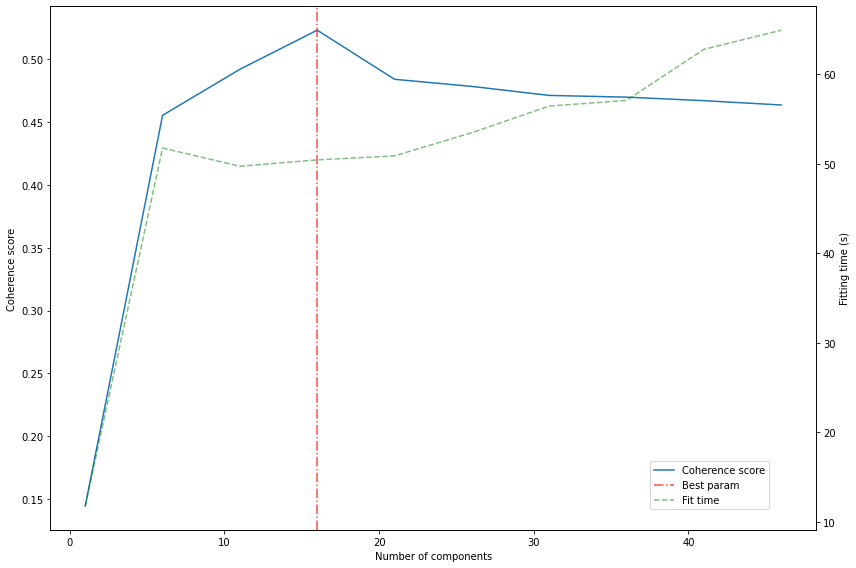

In [19]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

legend = fig.legend(loc='lower right', bbox_to_anchor=(.9, .1))

fig.tight_layout()
plt.show()

In [20]:
print(f"Le nombre optimal de topics obtenus est de {best_nb_topics}")

Le nombre optimal de topics obtenus est de 16


On va maintenant ré-entrainer le modèle avec ce nombre de topic et obtenir toute les probabilités ayant été calculées. Il est à noter que ce nombre peut varier entre 12 et 18, en fonction des hyperparamètres du modèle **`gensim`** ou du *random_state* par exemple, mais l'ordre de grandeur de la Cohérence reste autour de 0.5.

In [21]:
num_topic = best_nb_topics

lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                    id2word=dictionnaire,
                                                    num_topics=num_topic,
                                                    random_state=100,
                                                    passes=10,
                                                    iterations=150,
                                                    alpha=model_alpha,
                                                    workers=4)

In [22]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_ready, 
                                     dictionary=dictionnaire, 
                                     coherence='c_v')

# coherence_model_lda = CoherenceModel(model=lda_model, 
#                                      corpus=corpus, 
#                                      dictionary=dictionnaire, 
#                                      coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5117561539854789


In [23]:
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
pyLDAvis.enable_notebook()

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(lda_model, corpus, dictionnaire)

/home/ahea/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.173096 -0.067817       1        1  10.345882
5     -0.116471  0.049127       2        1   8.760472
12    -0.068767  0.176213       3        1   8.464584
10    -0.153279 -0.168294       4        1   7.570486
13     0.075744 -0.100241       5        1   7.394013
7      0.073204  0.122151       6        1   6.491066
0      0.064922  0.105616       7        1   6.364273
14     0.122939  0.057372       8        1   6.289683
1     -0.084712 -0.096114       9        1   5.965366
9     -0.175934  0.056020      10        1   5.838172
8     -0.053619  0.055562      11        1   5.697179
2      0.014609  0.097532      12        1   5.446602
4      0.079088 -0.056742      13        1   5.400626
11    -0.148672 -0.079845      14        1   4.136425
6      0.084034 -0.051773      15        1   2.968526
15     0.113819 -0.098766      16        1   2.866645, topic_info=           Term         Freq        Total Category  logprob  loglift
371       class  4875.000000  4875.000000  Default  30.0000  30.0000
32       object  4084.000000  4084.000000  Default  29.0000  29.0000
225       table  2746.000000  2746.000000  Default  28.0000  28.0000
310        java  4106.000000  4106.000000  Default  27.0000  27.0000
290      string  4332.000000  4332.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
253  difference   155.898827  2445.697830  Topic16  -5.0917   0.7991
379         set   128.664463  3909.489994  Topic16  -5.2837   0.1381
82      example   131.008594  4901.930451  Topic16  -5.2657  -0.0701
286     problem   114.973296  2979.506113  Topic16  -5.3962   0.2972
271       write   102.202858  2999.422655  Topic16  -5.5140   0.1728

[1155 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2867     16  0.983566         +
2277     13  0.949905       abc
2990      6  0.884005  abstract
2990      7  0.014182  abstract
2990      8  0.014182  abstract
...     ...       ...       ...
1261     15  0.044314      zero
247       3  0.017932      zone
247       8  0.950401      zone
247      10  0.017932      zone
4327      3  0.956347       zsh

[4698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 13, 11, 14, 8, 1, 15, 2, 10, 9, 3, 5, 12, 7, 16])

On va construire maintenant un dataframe qui contiendra pour chaque ligne : le topic dominant, la probabilité ainsi que les *keywords* associés.

In [24]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in tqdm(enumerate(ldamodel[corpus]), total=len(ldamodel[corpus])):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
                
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return (sent_topics_df)

###
# Format
df_dominant_topic = format_topics_sentences(lda_model)

# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

100%|██████████| 31024/31024 [02:01<00:00, 254.58it/s]


In [25]:
df_dominant_topic.sample(5)

,Dominant_Topic,Perc_Contribution,Topic_Keywords
16141,12.0,0.6578,"window, version, application, install, process, instal, build, project, python, program"
11361,15.0,0.4912,"key, character, value, word, python, dictionary, child, parent, encode, quote"
10023,9.0,0.3291,"app, android, iphone, application, device, user, google, io, api, xcode"
16895,0.0,0.4100,"method, call, test, exception, time, thread, throw, class, framework, c#"
23069,3.0,0.9100,"function, string, array, variable, number, value, example, return, c++, javascript"


In [26]:
df_dominant_topic.groupby('Dominant_Topic')['Topic_Keywords'].unique()

Dominant_Topic
0.0                     [method, call, test, exception, time, thread, throw, class, framework, c#]
1.0                                  [list, net, form, jquery, asp, page, item, select, mvc, user]
2.0                [model, django, client, address, send, email, user, pattern, interface, server]
3.0           [function, string, array, variable, number, value, example, return, c++, javascript]
4.0     [difference, property, method, function, parameter, return, js, understand, call, example]
5.0                         [php, javascript, server, request, page, url, web, user, log, browser]
6.0                               [python, index, loop, plot, point, r, label, graph, axis, close]
7.0                          [class, c, python, c++, module, project, path, compile, name, static]
8.0              [git, command, change, script, directory, branch, commit, date, repository, bash]
9.0                      [app, android, iphone, application, device, user, google, io, api, xc

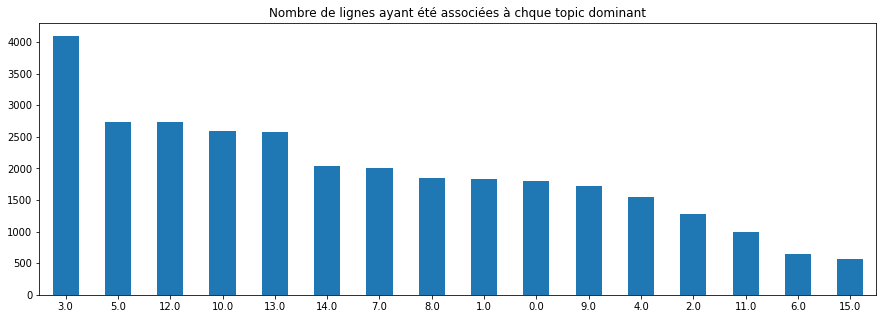

In [27]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind='bar', figsize=(15,5), rot=0)
plt.title("Nombre de lignes ayant été associées à chque topic dominant")
plt.show()

# <font color="blue" id=section_3_2> 3.2 Fonction "score" pour le système de suggestion.  </font>

Nous allons définir ici la fonction qui permettra d'établir le système de suggestions de tags. Cette dernière calculera un score entre deux textes basé sur les résultats de la modélisation LDA.

Soit $D$ le nombre le total de questions (ou de documents) que nous avons dans le train set. Soit $K$ le nombre total de topic identifés. La modélisation LDA permet de détermier une distribution de probabilités des topics pour chaque commentaire. Avec un paramètre $\alpha$ suffisament petit, on suppose que pour chaque commentaire il n'y a qu'un seul topic qui soit dominant (la probabilité des autres topic étant très petite relativement). De plus, on a également la distribution de probabilité des mots pour chaque topic . La fonction score se calculera comme :         

 - Soit $N$ le nombre total de mots dans le document de test $T$, on a alors une somme sur l'ensemble des mots du document test :          
 
    $$\large s = \Pi_{i=1}^{N} p(w_i/t) p(t/d) $$,
Où
 - $p(w_i/t)$ est la probabilité du mot $w_i$ pour le topic dominant $t$
 - $p(t/d)$ est la probabilité du toopic dominant $t$ pour le document $d$ 
 
 
Le système de suggestion sélectionnera donc parmi tout les documents du train set ceux avec le score le plus petit (on passera au logarithme dans la pratique). Les tags associés aux documents ainsi sélectionner seront donc suggérés au document test.

In [28]:
# On récupère d'abord la matrice des Documents/Topics

doc_all_topics = lda_model.get_document_topics(corpus)

mat_sparse = gensim.matutils.corpus2csc(doc_all_topics).T.toarray()

print(mat_sparse.shape)

mat_sparse

(31024, 16)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.48853981,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.47009963, 0.11327162,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.49880517, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.20329443, ..., 0.36618936, 0.        ,
        0.        ]])

#### On montre en premier comment ce système de suggestion fonctionne pour un seul commentaire.

In [29]:
def calcul_score_comm(phrase_test, mat_doc_topic=mat_sparse, dictionnaire=dictionnaire, lda_model=lda_model):
    
    # phrase test dominant topic
    test_topic_dist = np.array([tup[1] for tup in lda_model.get_document_topics(
        bow=dictionnaire.doc2bow(phrase_test),
        minimum_probability=0.0)
                             ])
    test_dom_topic_idx = np.argsort(test_topic_dist)[-1]
    
    # distribution des mots pour le topic dominant
    mots_dist = []
    for word in phrase_test:
        if word in dictionnaire.values():
            all_dist  = lda_model.get_term_topics(word, minimum_probability=0.0)
            if len(all_dist)==lda_model.num_topics:
                term_dist = all_dist[test_dom_topic_idx][1]
                if term_dist > 1e-3:
                    mots_dist.append(term_dist)
                
    # boucle sur les commentaires du train set
    score_comm = []
    for pos, i in enumerate(range(mat_doc_topic.shape[0])):
        
        train_dom_topic_idx = np.argsort(mat_doc_topic[i])[-1]
        
        # uniquement si test & train ont le même topic dominant
        if int(train_dom_topic_idx) == int(test_dom_topic_idx):
            train_test_top = mat_doc_topic[i][train_dom_topic_idx]

            # calcul score en appliquant le logarithme sur la formule précédente
            calcul_score = 0
            for i in range(len(mots_dist)):
                calcul_score += np.log(mots_dist[i]*train_test_top)
            
            # Append resultat pour chaque commentaire
            score_comm.append((pos,calcul_score))
                        
    return score_comm #, test_dom_topic_idx

In [30]:
df.columns

Index(['Best_Tags', 'Body_pc', 'Body_lm'], dtype='object')

In [31]:
test_df.shape[0]

800

In [32]:
# Document test que l'on choisi aléatoirement
iloc = randint(0,lda_test_df.shape[0])
print(iloc)

# print du Body original
lda_test_df[['Body_lm', 'Best_Tags']].iloc[iloc].to_frame().T

123


,Body_lm,Best_Tags
25577352,plot cdf pandas series python interface panda series plot cdf,[python]


In [33]:
phr_test = lda_test_feats.iloc[iloc]

score_phr_test = calcul_score_comm(phr_test)

In [37]:
score_phr_test_sorted = sorted(score_phr_test, key=lambda x: (x[1]), reverse=True)
score_phr_test_sorted[:10]

[(1476, -3.271172774580274),
 (4873, -3.2714268091508605),
 (11928, -3.2752617424023596),
 (10646, -3.2765411178914654),
 (2019, -3.2774762671698485),
 (2626, -3.2856844610816416),
 (851, -3.2887981580317915),
 (12539, -3.29001128984548),
 (4974, -3.291303080405052),
 (14558, -3.2926598583054063)]

In [38]:
## Parmi la sélection précédente, on peut choisir un "top_N" des suggestions
top_pos = [tup[0] for tup in score_phr_test_sorted]
pos     = top_pos[0]
# print(pos)

# On regarde le Topic Dominant & Keywords pour la "top_N" suggestion
df_dominant_topic[['Topic_Keywords', 'Dominant_Topic']].iloc[pos].to_frame().T

,Topic_Keywords,Dominant_Topic
1476,"python, index, loop, plot, point, r, label, graph, axis, close",6.0


In [40]:
# On recherche dans le train set
loc_train = train_feats.iloc[top_pos[:3]].index

df_sugg = train_df[['Body_lm','Best_Tags']].loc[loc_train] #.to_frame().T
df_sugg

,Body_lm,Best_Tags
Id,,
18379933,plot cumulative count post plot cumulative density ggplot currently accept answer plot cumulative frequency distribution ggplot plot cumulative count solution involve pre calculate value beforehand pure ggplot solution let show far ggplot ggplot plot cumulative density something follow idea next color start last color end ask well bad ideally simple fix complicated count last resort approach since give bad bin result,[r]
14423325,confidence interval prediction logistic regression r predict compute prediction base result linear regression offer compute confidence interval prediction accord manual interval base variance fitting interval coefficient hand predict glm compute prediction base logistic poisson regression amongst option confidence interval hard time imagine confidence interval compute provide meaningful insight poisson logistic regression case meaningful provide confidence interval prediction interpret assumption case,[r]
6189229,create oobb point create minimal oobb give point create aabb sphere problem create minimal oobb edit first answer result huge cloud point little amount point collision geometry generation example cube point side triangle point triangle algorithm first post give bad result cube example point cube return identity axis,[c++]


In [41]:
sugg_tags = [tag for tag_list in df_sugg['Best_Tags'].values.tolist() for tag in tag_list]

sugg_tags

['r', 'r', 'c++']

Il est possible que des mêmes tags puissent être associés aux meilleurs documents sugérés, la fonction ci-dessous permet d'en garder les éléments uniques.

In [48]:
def list_unique(list1, tag_max=3):
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
            
    if len(unique_list) <= tag_max:
        final_sugg = unique_list
    else:
        final_sugg = unique_list[:tag_max]
            
    return final_sugg

sugg_unq = list_unique(sugg_tags)
sugg_unq

['r', 'c++']

In [49]:
# Regardons les vrais tags associés au document test (voir plus haut)
df[['Best_Tags']].loc[lda_test_df.iloc[iloc].name].tolist()

[['python']]

# <font color="blue" id=section_3_3> 3.3 Inférence sur le test set. </font>

In [50]:
def suggestion_tags_LDA(test_set, mat_sparse=mat_sparse):
    all_tags = []
    test_dom_topic = []
    
    for i in tqdm(range(len(test_set)), total=len(test_set)):
        test_sent   = test_set[i]
#         scores_test, test_dom_topic_idx = calcul_score_comm(test_sent,mat_sparse)
        scores_test = calcul_score_comm(test_sent,mat_sparse)

        scores_sorted = sorted(scores_test, key=lambda x: (x[1]), reverse=True)[:3]

        ## Resultat
        top_pos = [tup[0] for tup in scores_sorted]
        pos     = top_pos

        # suggestions parmi le train set
        loc_train = train_feats.iloc[top_pos].index
        suggestions_list = train_df['Best_Tags'].loc[loc_train].values.tolist()

        sugg_tags = [tag for tag_list in suggestions_list for tag in tag_list]
        final_sugg = list_unique(sugg_tags)

#         if len(sugg_unq) <= 3:
#             final_sugg = sugg_unq
#         else:
#             final_sugg = sugg_unq[:3]
        
        all_tags.append(final_sugg)
#         test_dom_topic.append(test_dom_topic_idx)

    return all_tags #, test_dom_topic

In [51]:
pred_tags = suggestion_tags_LDA(lda_test_feats.tolist())

100%|██████████| 1620/1620 [04:17<00:00,  6.30it/s]


In [52]:
pred_tags[:10]

[['ios', 'iphone', 'android'],
 ['java', 'ruby', 'html'],
 ['c++', 'java', 'c#'],
 ['javascript', 'jquery', 'asp.net'],
 ['mysql', 'performance', 'sql'],
 ['c#', 'json', 'java'],
 ['java', 'c#'],
 ['c++', 'javascript', 'algorithm'],
 ['c++', 'ruby', 'windows'],
 ['ios', 'iphone', 'android']]

In [53]:
lda_test_tags = mlb.inverse_transform(lda_test_label)
lda_test_tags[:10]

[('.net', 'c#'),
 ('ruby-on-rails',),
 ('linux',),
 ('jquery',),
 ('mysql', 'sql'),
 ('c#',),
 ('c',),
 ('php',),
 ('c#',),
 ('android',)]

## Évaluation des suggestions 

In [54]:
from sklearn.metrics import classification_report
lda_pred_label  = mlb.transform(pred_tags)

report = pd.DataFrame(classification_report(
    lda_test_label,
    lda_pred_label,
    output_dict=True,
    target_names=tags_list,
    zero_division=0
)).T

In [55]:
avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]
avg_report = report.loc[avg_index]
avg_report

,precision,recall,f1-score,support
samples avg,0.182407,0.363889,0.233272,2089.0
weighted avg,0.179563,0.358545,0.195016,2089.0
macro avg,0.130706,0.280396,0.143512,2089.0
micro avg,0.170732,0.358545,0.231316,2089.0


In [89]:
clf_report = report[~report.index.isin(avg_report.index)]
clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
django,0.120915,0.196809,0.149798,188.0
mysql,0.207229,0.464865,0.286667,185.0
linux,0.216906,0.755556,0.337051,180.0
php,0.176638,0.366864,0.238462,169.0
c#,0.397260,0.491525,0.439394,118.0
ios,0.123967,0.833333,0.215827,90.0
python,1.000000,0.012500,0.024691,80.0
sql,0.000000,0.000000,0.000000,74.0
ruby,0.000000,0.000000,0.000000,68.0
html,0.000000,0.000000,0.000000,64.0


# <font color="blue" id=section_4> 4. Suggestion avec modèle Word2Vec </font>

In [58]:
# On utilisera la fonction ci-dessous pour afficher l'historique de l'entraînement des modèles

def plot_model_history(model):
            
    acc      = model.history.history[list(model.history.history.keys())[1]]
    val_acc  = model.history.history[list(model.history.history.keys())[3]]
    loss     = model.history.history[list(model.history.history.keys())[0]]
    val_loss = model.history.history[list(model.history.history.keys())[2]]
    epochs   = model.history.epoch

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()  

In [59]:
body = 'Body_lm'

In [60]:
w2v_train_feats = train_df[body].apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(w2v_train_feats.shape))

w2v_train_label = train_label_bin.copy()
print("Shape of y train: {}".format(w2v_train_label.shape))

Shape of x train: (31024,)
Shape of y train: (31024, 35)


In [61]:
w2v_test_feats = test_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(w2v_test_feats.shape))

w2v_test_label = test_label_bin.copy()
print("Shape of y test: {}".format(w2v_test_label.shape))

Shape of x test: (800,)
Shape of y test: (800, 35)


In [62]:
w2v_eval_feats = eval_df[body].apply(lambda x: x.split(" ")) 
print("Shape of x eval: {}".format(w2v_eval_feats.shape))

w2v_eval_label = eval_label_bin.copy()
print("Shape of y eval: {}".format(w2v_eval_label.shape))

Shape of x eval: (820,)
Shape of y eval: (820, 35)


## Tokenization

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(w2v_train_feats) 

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)


train_sequences = tokenizer.texts_to_sequences(w2v_train_feats) 
train_padded = pad_sequences(
    train_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

test_sequences = tokenizer.texts_to_sequences(w2v_test_feats) 
test_padded = pad_sequences(
    test_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

eval_sequences = tokenizer.texts_to_sequences(w2v_eval_feats) 
eval_padded = pad_sequences(
    eval_sequences, 
    maxlen=maxSeq_len, 
    truncating="post", 
    padding="post"
)

Number of unique words: 23832


## Création du modèle Word2Vec

In [64]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=10

In [65]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=8)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(w2v_train_feats)
w2v_model.train(w2v_train_feats, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 23831
Word2Vec trained


## Création de la matrice d'embedding

In [67]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
# word_rate = np.round(j/i,4)
# print("Word embedding rate : ", word_rate)
print("Embedding matrix shape: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Embedding matrix shape: (23832, 300)


## Entraînement du modèle

In [68]:
word_input         = keras.layers.Input(shape=(maxSeq_len,), dtype='float64')  
word_embedding     = keras.layers.Embedding(input_dim    = vocab_size,
                                            output_dim   = w2v_size,
                                            weights      = [embedding_matrix],
                                            input_length = maxSeq_len)(word_input)

x                  = keras.layers.GlobalAveragePooling1D()(word_embedding)  
x                  = keras.layers.Dropout(0.1)(x) # 0.3
word_output        = keras.layers.Dense(nbr_tags, activation='softmax')(x)
w2v_embed_model    = keras.models.Model([word_input],word_output)

w2v_embed_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

w2v_embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding (Embedding)       (None, 64, 300)           7149600   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 35)                10535     
                                                                 
Total params: 7,160,135
Trainable params: 7,160,135
Non-trainable params: 0
___________________________________________________

In [69]:
# from keras.callbacks import ModelCheckpoint
# #create callback
# filepath = 'best_w2v.hdf5'

# checkpoint = ModelCheckpoint(filepath=filepath, 
#                              monitor='val_loss',
#                              verbose=1, 
#                              save_best_only=True,
#                              mode='min')
# callbacks = [checkpoint]

In [70]:
w2v_history = w2v_embed_model.fit(
    train_padded,
    train_label_bin,
    epochs=20,
    batch_size=128,
    validation_data=[eval_padded, 
                     eval_label_bin],
    verbose=1,
#     callbacks=callbacks
)

Epoch 1/20
243/243 [==============================] - 21s 86ms/step - loss: 0.2283 - accuracy: 0.1847 - val_loss: 0.1334 - val_accuracy: 0.3073
Epoch 2/20
243/243 [==============================] - 20s 84ms/step - loss: 0.1255 - accuracy: 0.3520 - val_loss: 0.1143 - val_accuracy: 0.4085
Epoch 3/20
243/243 [==============================] - 20s 83ms/step - loss: 0.1082 - accuracy: 0.4364 - val_loss: 0.1007 - val_accuracy: 0.4780
Epoch 4/20
243/243 [==============================] - 20s 84ms/step - loss: 0.0956 - accuracy: 0.5023 - val_loss: 0.0906 - val_accuracy: 0.5220
Epoch 5/20
243/243 [==============================] - 20s 84ms/step - loss: 0.0860 - accuracy: 0.5523 - val_loss: 0.0831 - val_accuracy: 0.5610
Epoch 6/20
243/243 [==============================] - 21s 85ms/step - loss: 0.0786 - accuracy: 0.5933 - val_loss: 0.0775 - val_accuracy: 0.5854
Epoch 7/20
243/243 [==============================] - 20s 84ms/step - loss: 0.0727 - accuracy: 0.6231 - val_loss: 0.0732 - val_accuracy:

# Evaluation du model

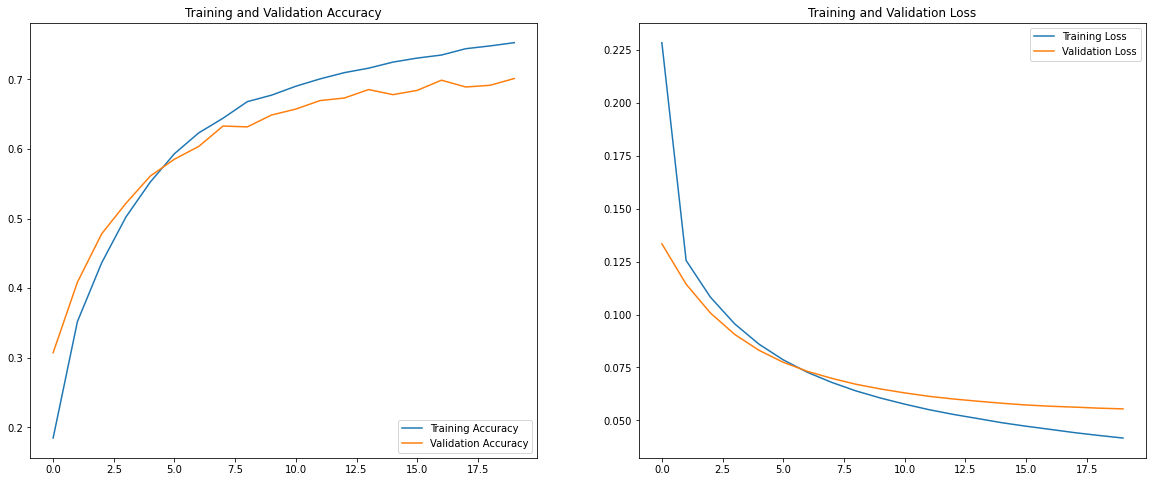

In [71]:
plot_model_history(w2v_embed_model)

In [72]:
w2v_embed_model.evaluate(test_padded, w2v_test_label)

25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - accuracy: 0.6925


[0.05523531511425972, 0.6924999952316284]

## Inférence sur le test set

In [73]:
w2v_pred_proba = w2v_embed_model.predict(test_padded)

25/25 [==============================] - 0s 2ms/step


In [87]:
# On ne garde que les index avec une probabilité softmax supérieur à un seuil 'tresh'
tresh = 0.3
w2v_pred_proba[w2v_pred_proba >= tresh] = 1
w2v_pred_proba[w2v_pred_proba < tresh] = 0

# Inverse transform
w2v_pred_inversed = mlb.inverse_transform(w2v_pred_proba)
w2v_test_inversed = mlb.inverse_transform(w2v_test_label)

pos = randint(0,test_label_bin.shape[0])
# display(test_df[body].iloc[pos])
# print()
print('predicted label :=', w2v_pred_inversed[pos])
print('actual label :=',w2v_test_inversed[pos])

predicted label := ('json', 'node.js')
actual label := ('javascript', 'json', 'node.js')


## Évaluation des suggestions

In [78]:
w2v_report = pd.DataFrame(classification_report(
    w2v_test_label,
    w2v_pred_proba,
    output_dict=True,
    target_names=tags_list,
    zero_division=0
)).T

avg_index = ['samples avg', 'weighted avg','macro avg', 'micro avg' ]
w2v_avg_report = w2v_report.loc[avg_index]
w2v_avg_report

,precision,recall,f1-score,support
samples avg,0.793125,0.702083,0.725250,1042.0
weighted avg,0.851322,0.636276,0.709911,1042.0
macro avg,0.829644,0.572771,0.657647,1042.0
micro avg,0.851091,0.636276,0.728171,1042.0


In [88]:
w2v_clf_report = w2v_report[~w2v_report.index.isin(w2v_avg_report.index)]
w2v_clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
mysql,0.904255,0.833333,0.867347,102.0
php,0.682353,0.698795,0.690476,83.0
django,0.943662,0.858974,0.899329,78.0
linux,0.918367,0.584416,0.714286,77.0
c#,0.949153,0.875000,0.910569,64.0
ios,0.829787,0.829787,0.829787,47.0
python,0.705882,0.292683,0.413793,41.0
sql,0.850000,0.472222,0.607143,36.0
ruby,0.896552,0.764706,0.825397,34.0
html,0.933333,0.424242,0.583333,33.0


# <font color="blue" id=section_5> 5. Modélisation via Transfer Learning. </font>

Ici, nous utilisons la colonne `Body_pc` qui contient les ponctuations.

In [94]:
body = 'Body_pc'

In [95]:
tl_train_feats = train_df[body] #.apply(lambda x: x.split(" ")).copy()
print("Shape of x train: {}".format(tl_train_feats.shape))

tl_train_label = train_label_bin.copy()
print("Shape of y train: {}".format(tl_train_label.shape))

Shape of x train: (31024,)
Shape of y train: (31024, 35)


In [96]:
tl_test_feats = test_df[body] #.apply(lambda x: x.split(" ")) 
print("Shape of x test: {}".format(tl_test_feats.shape))

tl_test_label = test_label_bin.copy()
print("Shape of y test: {}".format(tl_test_label.shape))

Shape of x test: (800,)
Shape of y test: (800, 35)


In [97]:
tl_eval_feats = eval_df[body] #.apply(lambda x: x.split(" ")) 
print("Shape of x eval: {}".format(tl_eval_feats.shape))

tl_eval_label = eval_label_bin.copy()
print("Shape of y eval: {}".format(tl_eval_label.shape))

Shape of x eval: (820,)
Shape of y eval: (820, 35)


# <font color="blue" id=section_5_1> 5.1 Suggestion avec le modèle BERT. </font>

In [90]:
import tensorflow_hub as hub
import tensorflow_text as text

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [91]:
# Bert input
text_input        = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
encoded_text      = bert_encoder(preprocessed_text)
sequence_output   = encoded_text['sequence_output']

# Neural network layers
b  = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
b = tf.keras.layers.Dense(128, activation='relu')(b)
b = tf.keras.layers.Dropout(0.3)(b)
b_out = tf.keras.layers.Dense(nbr_tags, activation='softmax')(b)

bert_embed_model = tf.keras.Model(inputs=[text_input], outputs = b_out)

bert_embed_model.compile(optimizer=tf.keras.optimizers.Adam(2e-6), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])


bert_embed_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [92]:
# #create callback
# from keras.callbacks import ModelCheckpoint
# filepath = 'best_bert_v4_AR.hdf5'

# checkpoint = ModelCheckpoint(filepath=filepath, 
#                              monitor='val_loss',
#                              verbose=1, 
#                              save_best_only=True,
#                              mode='min')
# callbacks = [checkpoint]

In [98]:
bert_history = bert_embed_model.fit(tl_train_feats, 
                                    tl_train_label,
                                    validation_data=[tl_eval_feats, 
                                                    tl_eval_label],
                                    batch_size=32,
                                    epochs=10,
                        #           callbacks=callbacks
                        )

Epoch 1/10


KeyboardInterrupt: 

## Évaluation du modèle 

In [125]:
plot_model_history(bert_embed_model)

IndexError: list index out of range

In [ ]:
bert_embed_model.evaluate(evaluate(tl_test_feats, tl_test_label)

## Inférence sur le test set

In [ ]:
bert_pred_proba = bert_embed_model.predict(tl_test_feats)

In [ ]:
tresh = 0.7
bert_pred_proba[bert_pred_proba >= tresh] = 1
bert_pred_proba[bert_pred_proba < tresh] = 0

# Inverse transform
bert_pred_inversed = mlb.inverse_transform(bert_pred_proba)
bert_test_inversed = mlb.inverse_transform(tl_test_label)

pos = randint(0,bert_pred_proba.shape[0])
display(test_df.iloc[pos])
print()
print('predicted label :=', bert_pred_inversed[pos])
print('actual label :=',bert_test_inversed[pos])

## Évaluation des suggestions

In [78]:
bert_report = pd.DataFrame(classification_report(
    bert_test_label,
    bert_pred_proba,
    output_dict=True,
    target_names=tags_list,
    zero_division=0
)).T

bert_avg_report = bert_report.loc[avg_index]
bert_avg_report

,precision,recall,f1-score,support
samples avg,0.793125,0.702083,0.725250,1042.0
weighted avg,0.851322,0.636276,0.709911,1042.0
macro avg,0.829644,0.572771,0.657647,1042.0
micro avg,0.851091,0.636276,0.728171,1042.0


In [88]:
bert_clf_report = bert_report[~bert_report.index.isin(bert_avg_report.index)]
bert_clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
mysql,0.904255,0.833333,0.867347,102.0
php,0.682353,0.698795,0.690476,83.0
django,0.943662,0.858974,0.899329,78.0
linux,0.918367,0.584416,0.714286,77.0
c#,0.949153,0.875000,0.910569,64.0
ios,0.829787,0.829787,0.829787,47.0
python,0.705882,0.292683,0.413793,41.0
sql,0.850000,0.472222,0.607143,36.0
ruby,0.896552,0.764706,0.825397,34.0
html,0.933333,0.424242,0.583333,33.0


# <font color="blue" id=section_5_2> 5.2 Suggestion avec le modèle USE. </font>

In [85]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
use_embed = hub.KerasLayer(module_url, trainable=True)

In [86]:
def build_model():
    
    model = keras.Sequential([
        keras.Input(shape=[], dtype=tf.string),
        use_embed,
        keras.layers.Dropout(0.3),
        keras.layers.Dense(nbr_tags, activation='softmax')
    ])
    
#     model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=tf.keras.optimizers.Adam(5e-4),
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])
    
    return model

use_embed_model = build_model()
use_embed_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 35)                17955     
                                                                 
Total params: 147,372,835
Trainable params: 147,372,835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
use_history = use_embed_model.fit(tl_train_feats, 
                                  tl_train_label,
                                  validation_data=[tl_eval_feats, 
                                                  tl_eval_label],
                                  batch_size=256,
                                  epochs=10,
                        #           callbacks=callbacks
                        )

## Évaluation du modèle 

In [ ]:
plot_model_history(use_embed_model)

In [ ]:
use_embed_model.evaluate(evaluate(tl_test_feats, tl_test_label)

## Inférence sur le test set

In [ ]:
use_pred_proba = use_embed_model.predict(tl_test_feats)

In [ ]:
tresh = 0.7
use_pred_proba[use_pred_proba >= tresh] = 1
use_pred_proba[use_pred_proba < tresh] = 0

# Inverse transform
use_pred_inversed = mlb.inverse_transform(use_pred_proba)
use_test_inversed = mlb.inverse_transform(tl_test_label)

pos = randint(0,use_pred_proba.shape[0])
display(test_df.iloc[pos])
print()
print('predicted label :=', use_pred_inversed[pos])
print('actual label :=',use_test_inversed[pos])

## Évaluation des suggestions

In [78]:
use_report = pd.DataFrame(classification_report(
    use_test_label,
    use_pred_proba,
    output_dict=True,
    target_names=tags_list,
    zero_division=0
)).T

use_avg_report = use_report.loc[avg_index]
use_avg_report

,precision,recall,f1-score,support
samples avg,0.793125,0.702083,0.725250,1042.0
weighted avg,0.851322,0.636276,0.709911,1042.0
macro avg,0.829644,0.572771,0.657647,1042.0
micro avg,0.851091,0.636276,0.728171,1042.0


In [88]:
bert_clf_report = bert_report[~bert_report.index.isin(bert_avg_report.index)]
bert_clf_report.sort_values(by='support', ascending=False)

,precision,recall,f1-score,support
mysql,0.904255,0.833333,0.867347,102.0
php,0.682353,0.698795,0.690476,83.0
django,0.943662,0.858974,0.899329,78.0
linux,0.918367,0.584416,0.714286,77.0
c#,0.949153,0.875000,0.910569,64.0
ios,0.829787,0.829787,0.829787,47.0
python,0.705882,0.292683,0.413793,41.0
sql,0.850000,0.472222,0.607143,36.0
ruby,0.896552,0.764706,0.825397,34.0
html,0.933333,0.424242,0.583333,33.0
